In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from tqdm import tqdm
import  numpy

In [195]:
class Particle:
    
    def __init__(self, r0, v0, a0, t, m=1, radius=2., g = -10, Id=0):
        
        self.dt = t[1] - t[0]
        
        
        # Atributos instantaneos
        self.g = g
        self.r = r0
        self.v = v0
        self.a = a0 + g
        
        self.m = m
        self.radius = radius
        self.Id = Id
        
        
        self.p = self.m*self.v
        
        self.f = self.m*self.a
        
        self.u = 0
        # Historial
        
        self.R = np.zeros((len(t),len(r0)))
        self.V = np.zeros_like(self.R)
        self.A = np.zeros_like(self.R)
        
        self.F = np.zeros_like(self.R)
        
        self.P = np.zeros_like(self.R)
        
        self.U = np.zeros(len(t))
        # Fisica
        self.K = 20.
        
        self.VEk = np.zeros(len(t))
        
    def Evolution(self,i):
        
        
        self.SetPosition(i)
        self.SetVelocity(i)
        self.SetPotentialEnergy(i)
        
        self.a = self.f/self.m
        self.a[1] = self.g
        
        # Euler
        self.r += self.dt*self.v
        self.v += self.dt*self.a
        
        # Euler-Cromer
  #      self.v += self.dt*self.a
  #      self.r += self.dt*self.v
        
        
    def CalculateForce(self,p,i):
        
        d = np.linalg.norm(self.r - p.r)
        
        compresion = self.radius + p.radius - d
        
        if compresion >= 0:
            
            Fn = self.K * compresion**3
            
            self.n = (self.r - p.r)/d     
            self.f = np.add(self.f,Fn*self.n)
            # Falta implementar energía potencial 
            
    # Aca debes agregar la energía potencial
    def ResetForce(self):
        self.f[:] = 0.
        self.a[:] = 0.
        
    # Setter
    def SetPosition(self,i):
        self.R[i] = self.r
        
    def SetPotentialEnergy(self,i):
           self.U[i] = (self.m * (self.r[1] + 20.) * self.g)
    
    def SetVelocity(self,i):
        self.V[i] = self.v
        self.P[i] = self.m*self.v
        self.VEk[i] = 0.5*self.m*np.dot(self.v,self.v)
        #self.U[i] = (np.linalg.norm(self.f) * compresion)/2
            
    # Getter
    def GetPosition(self,scale=1):
        return self.R[::scale]
    
    def GetVelocity(self,scale=1):
        return self.V[::scale]
 
    def GetMomentum(self,scale=1):
        return self.P[::scale]
    
    def GetKineticEnergy(self,scale=1):
        return self.VEk[::scale] 
    
    def GetPotentialEnergy(self,scale=1):
        return self.U[::scale] 
    
    # Debes agregar las paredes en este punto
    
    def CheckLimits(self):
        
        for i in range(2):
            
            if self.r[i] + self.radius > 20 and self.v[i] > 0.:
                self.v[i] = -self.v[i] * 0.9
            elif self.r[i] - self.radius < -20 and self.v[i] < 0.:
                self.v[i] = -self.v[i] * 0.9

In [196]:
def GetParticles(N,t):
    
    r0 = np.array([-15., -10.])
    v0 = np.array([2.,0])
    a0 = np.array([0.,0.])
    
    p0 = Particle(r0,v0,a0,t,m=1,radius=2, g = -10.,Id=0)
    
    Particles = [p0]
    
    # Aca deber agregar una rutina montecarlo para crear particulas
    # sobre el plano con velocidades aleatorias.
    
    return Particles

In [197]:
dt = 0.001
tmax = 30
t = np.arange(0,tmax,dt)
Particles = GetParticles(1,t)

In [198]:
def RunSimulation(t,Particles):
    
    for it in tqdm(range(len(t)), desc='Running simulation', unit=' Steps' ):
        
        for i in range(len(Particles)):
            for j in range(len(Particles)):
                if i!=j:
                    Particles[i].CalculateForce(Particles[j])
        
        for i in range(len(Particles)):
            Particles[i].Evolution(it)
            Particles[i].ResetForce()
            Particles[i].CheckLimits()
            # Aca debes agregar la interaccion con la pared
            
            
    return Particles

In [199]:
Particles = RunSimulation(t,Particles)

Running simulation: 100%|█████████████████████████████████████████████████| 30000/30000 [00:00<00:00, 61856.14 Steps/s]


In [200]:
scale = 100
t1 = t[::scale]

<IPython.core.display.Javascript object>


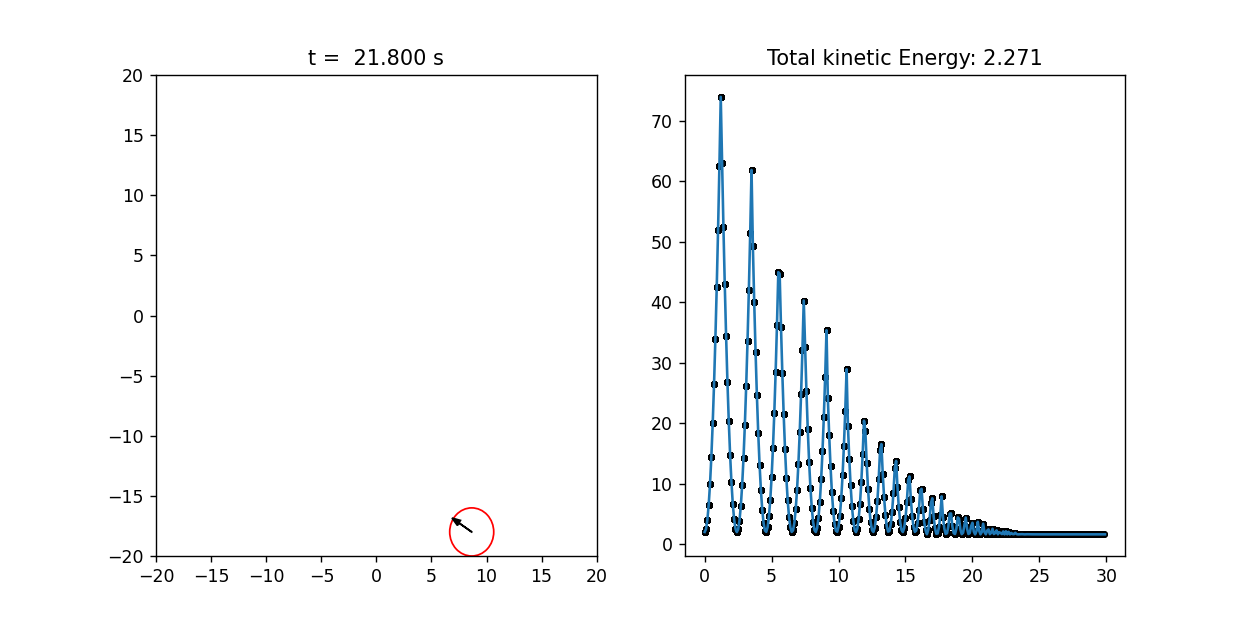

In [201]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)
ax1 = fig.add_subplot(122)

def init():
    
    ax.clear()
    ax.set_xlim(-20,20)
    ax.set_ylim(-20,20)
    
def Update(i):
    
    init()
    ax.set_title(r't =  %.3f s' %(t1[i]))
    
    
    # Queremos calcular la energía total de cinética
    KE = 0. # Kinetic energy
    
    for p in Particles:
        
        x = p.GetPosition(scale)[i,0]
        y = p.GetPosition(scale)[i,1]
        
        vx = p.GetVelocity(scale)[i,0]
        vy = p.GetVelocity(scale)[i,1]
        
        circle = plt.Circle( (x,y), p.radius, color='r', fill=False )
        ax.add_patch(circle)
        
        ax.arrow(x,y,vx,vy,color='k',head_width=0.5,length_includes_head=True)
        
        KE += p.GetKineticEnergy(scale)[i]
        
        ax1.set_title(r'Total kinetic Energy: {:.3f}'.format(KE))
        ax1.scatter(t1[:i], p.GetKineticEnergy(scale)[:i],color='k',marker='.')
        
Animation = anim.FuncAnimation(fig,Update,frames=len(t1),init_func=init)

a) Entre 22 y 23 segundos la velocidad de la pelota se reduce significativamente.

In [202]:
plt.plot(t1,Particles[0].GetKineticEnergy(scale)[:])

In [203]:
MomentumT = Particles[0].GetMomentum(scale)

In [204]:
for i in range(1,len(Particles)):
    MomentumT = np.add(MomentumT,Particles[i].GetMomentum(scale))

<IPython.core.display.Javascript object>


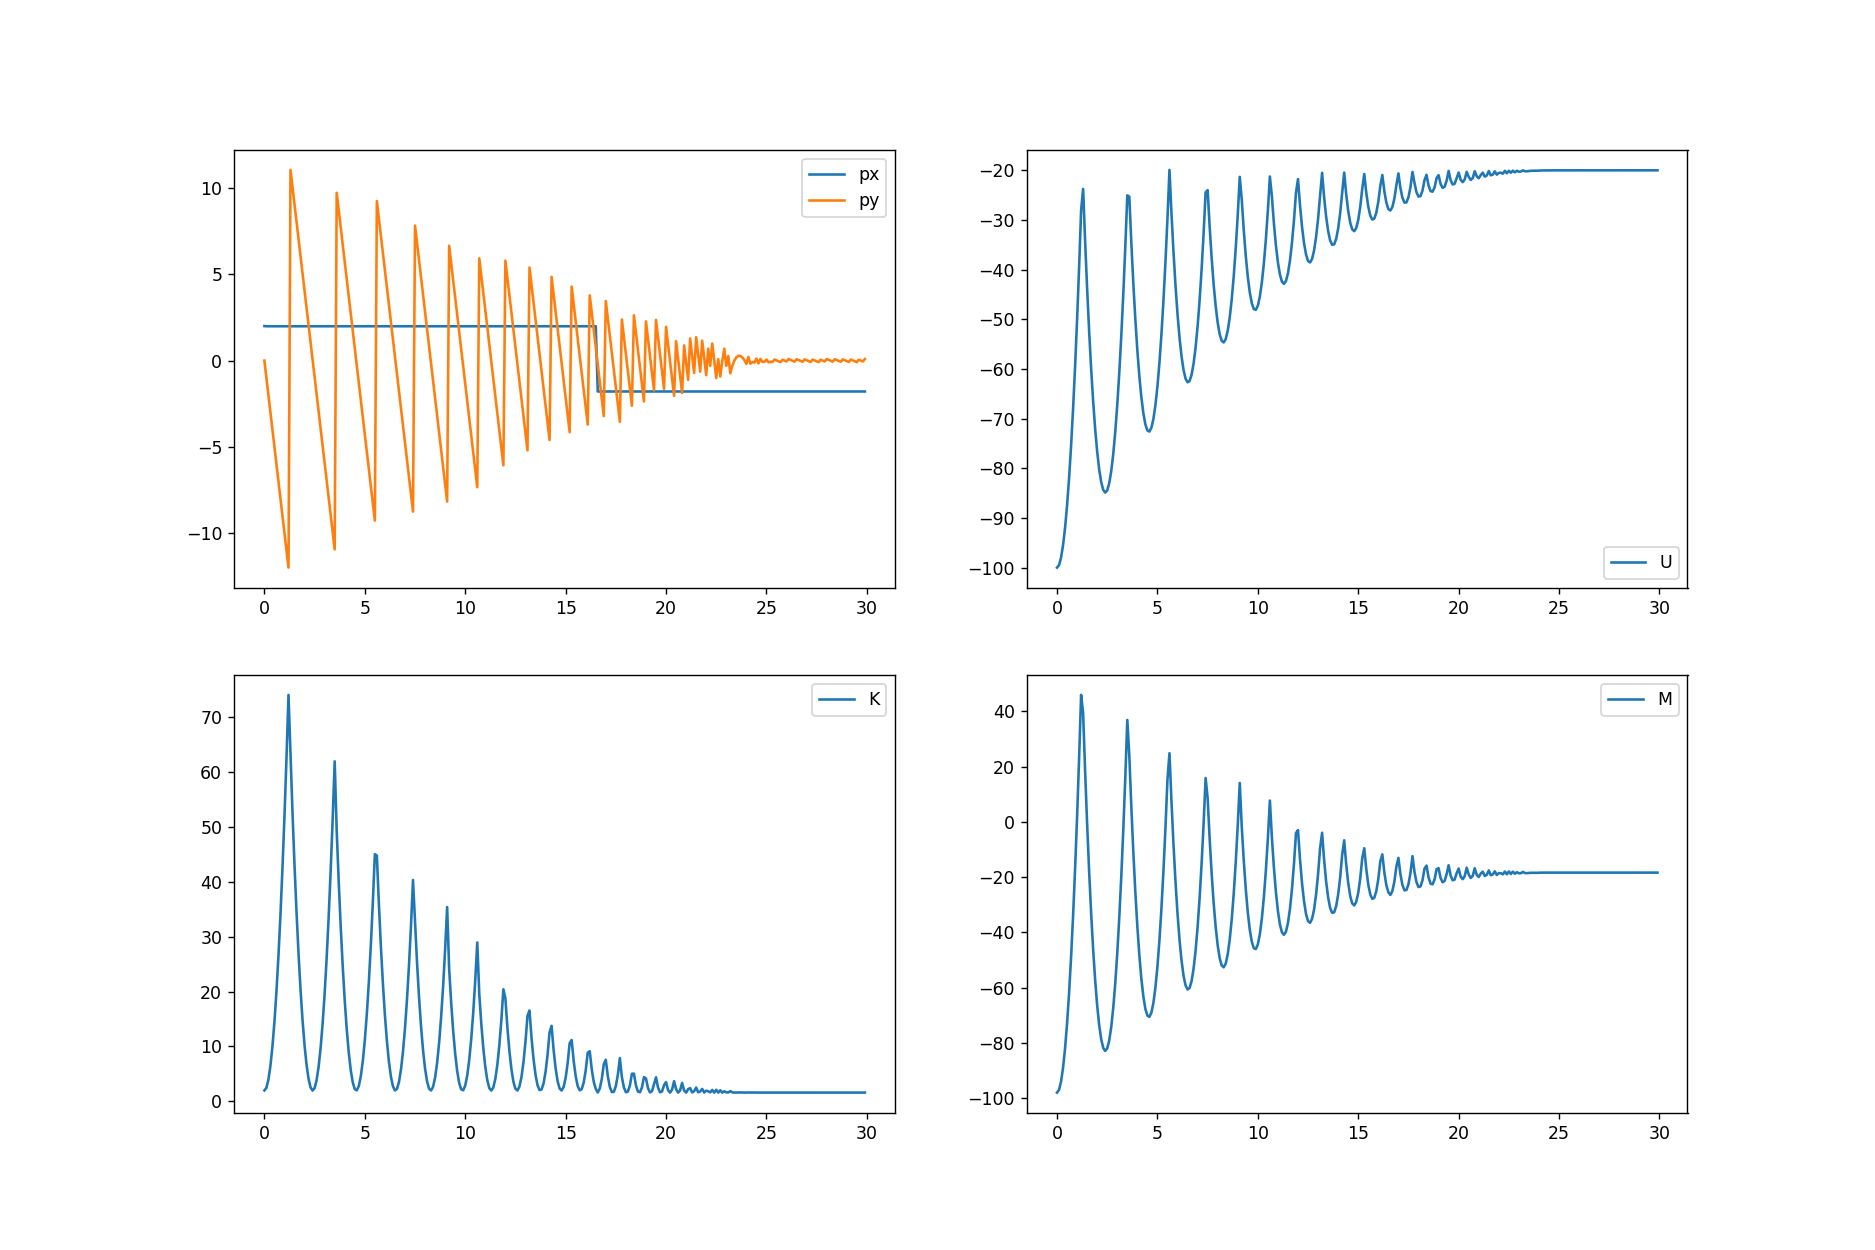

In [205]:
# Plot momentum, potential energy, kinetic energy, and M in a single figure
MomentumT = Particles[0].GetMomentum(scale)
for i in range(1, len(Particles)):
    MomentumT = np.add(MomentumT, Particles[i].GetMomentum(scale))

fig2, axs2 = plt.subplots(2, 2, figsize=(15, 10))
axs2[0, 0].plot(t1, MomentumT[:, 0], label='px')
axs2[0, 0].plot(t1, MomentumT[:, 1], label='py')
axs2[0, 0].legend()

PotentialEnergyT = Particles[0].GetPotentialEnergy(scale)
for i in range(1, len(Particles)):
    PotentialEnergyT = np.add(PotentialEnergyT, Particles[i].GetPotentialEnergy(scale))

axs2[0, 1].plot(t1, PotentialEnergyT, label='U')
axs2[0, 1].legend()

KineticEnergyT = Particles[0].GetKineticEnergy(scale)
for i in range(1, len(Particles)):
    KineticEnergyT = np.add(KineticEnergyT, Particles[i].GetKineticEnergy(scale))

axs2[1, 0].plot(t1, KineticEnergyT, label='K')
axs2[1, 0].legend()

axs2[1, 1].plot(t1, KineticEnergyT + (PotentialEnergyT), label='M')
axs2[1, 1].legend()

plt.show()

Segun la grafica de energia potencial. El primer pico lo alcanza en -100 y el segundo pico lo alcanza en -85. Despejando las alturas de ahi nos dan h1 = 10 y h2 = -8,5. Haciendo el calculo con la formula nos da: 0,922

In [209]:
round(0.85**0.5,4)

0.922

In [210]:
def f(theta,thethaVelocity, g, L):
    
    dthetha_dt = thethaVelocity
    dthethaVelocity_dt = ( ((2*g*L**-1)-thethaVelocity*np.cos(theta))*np.sin(theta) ) / (1/3) + (np.sin(theta))**2
    
    derivadas = np.array([dthetha_dt,dthethaVelocity_dt])
    
    return derivadas

In [ ]:



theta0 = 10*pi/180
thethaVelocity = 0
L = 1
g = 10

In [211]:
def System(r,t,b):
    
    x,y,vx,vy = r
    
    dxdt = vx
    dydt = vy
    dvxdt = 0. - b*vx
    dvydt = - g - b*vy
    
    return [dxdt,dydt,dvxdt,dvydt]